**Important**:
Follow the instructions below when submitting your attempt.
Submissions not following these instructions will not be graded.

1. **Use JupyterLab**. Other notebook-editing software (e.g. VSCode, pycharm) might corrupt the notebook files.
3. **Do not remove, modify or duplicate** any given cells, except those in which you need to fill in your implementation. You can add new cells in order to present additional texts or plots.
4. **Restart the kernel and re-run the whole notebook** once before submission. After this step, the cell id should be incremental from top to bottom, and all plots should be displayed.
5. **Submit only the `.ipynb` files**, do not upload archives (zip, rar, tar, etc.), images or datasets.
6. **Do not change the filenames** of the `.ipynb` files.

# 3D Reconstruction

This exercise will guide you through two common operations we can apply to point correspondences extracted from stereo image pairs:

1. Estimation of the fundamental matrix on perfect matches.
2. Implementation of RANSAC to take care of incorrect maches.
3. Triangulation of 3D scene points given their projected image coordinates and the camera matrices.

We will use pre-computed point correspondences (loaded from file).

In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import cv2
import os
from scipy import signal

def load_data(d_name):
    """ Load images and matches.
    
    Args:
        d_name: Should be 'house' or 'library'
        
    Returns:
        img0, img1: Images
        x0, x1: 3xN matrix of matching points
        P0, P1: 3X4 camera matrix
    """
    img0 = imageio.imread(f'{d_name}1.jpg')
    img1 = imageio.imread(f'{d_name}2.jpg')
    x0 = np.genfromtxt(f'{d_name}_matches_x1.csv', delimiter=',', dtype=np.float64)
    x1 = np.genfromtxt(f'{d_name}_matches_x2.csv', delimiter=',', dtype=np.float64)
    P0 = np.loadtxt(f'{d_name}1_camera.txt')
    P1 = np.loadtxt(f'{d_name}2_camera.txt')
    return img0, img1, x0, x1, P0, P1

def plot_multiple(images, titles=None, colormap='gray', 
                  max_columns=np.inf, imwidth=4, imheight=4, share_axes=False):
    """Plot multiple images as subplots on a grid."""
    if titles is None:
        titles = [''] *len(images)
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * imwidth, n_rows * imheight),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    fig.tight_layout()
    
def draw_keypoints(img, x):
    img = img.copy()
    for p, color in zip(x.T, colors):
        cv2.circle(img, (int(p[0]), int(p[1])), thickness=2, radius=1, color=color)
    return img

def random_colors(n_colors):
    """Create a color map for visualizing the labels themselves,
    such that the segment boundaries become more visible, unlike
    in the visualization using the cluster peak colors.
    """
    import matplotlib.colors
    rng = np.random.RandomState(2)
    values = np.linspace(0, 1, n_colors)
    colors = plt.cm.get_cmap('hsv')(values)
    rng.shuffle(colors)
    return colors*255

colors = random_colors(1000)
    
def draw_point_matches(img0, img1, x0, x1, color_mask=None):
    result = np.concatenate([img0, img1], axis=1)
    img0_width = img0.shape[1]
    
    if color_mask is None:
        color_mask = np.ones(x0.shape[1], dtype=bool)
        
    for p0, p1, c_flag, color in zip(x0.T, x1.T, color_mask, colors):
        p0x, p0y = int(p0[0]), int(p0[1])
        p1x, p1y = int(img0_width + p1[0]), int(p1[1])
        cv2.line(result, (p0x, p0y), (p1x, p1y),
                 color=color, thickness=1, lineType=cv2.LINE_AA)
    return result

def draw_line(img, l, color):
    if abs(l[0]) < abs(l[1]):
        # More horizontal
        slope = -l[0] / l[1]
        intercept = -l[2] / l[1]
        xs = np.array([0, img.shape[1]])
        ys = intercept + slope * xs
        cv2.line(img, (int(xs[0]), int(ys[0])), (int(xs[1]), int(ys[1])),
                 color=color, thickness=1, lineType=cv2.LINE_AA)
    else:
        # More vertical
        slope = -l[1] / l[0]
        intercept = -l[2] / l[0]
        ys = np.array([0, img.shape[0]])
        xs = intercept + slope * ys
        cv2.line(img, (int(xs[0]), int(ys[0])), (int(xs[1]), int(ys[1])),
                 color=color, thickness=1, lineType=cv2.LINE_AA)

def draw_points_and_epipolar_lines(img, points, lines):
    """
    Args:
        img: First or second image
        x: 3xN matrix of points (on the same image)
        l: 3xN matrix of lines (on the same image)
    """
    points = points[:2] / points[2]  # Normalize
    img = img.copy()
    
    for l, color in zip(lines.T, colors):
        draw_line(img, l, color)

    for (x,y), color in zip(points.T, colors):
        cv2.circle(img, (int(x), int(y)), thickness=2, radius=1, color=color)

    return img

C:\Users\Haoling Yang\AppData\Local\Temp\ipykernel_23160\740770910.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv')(values)


## Essential vs. Fundamental Matrix

Both these matrices describe a relation between points in two images. Given a point in one image, they both allow to compute an epipolar line in the other image which contains all the possible locations of the observed world point in the second image. So what's the difference?

The essential matrix describes the points on the images in normalized image coordinates. You can compute the normalized image coordinates of a 3D world point (in meters) by first transforming it into the camera coordinate system using $X^\text{cam} = [\mathrm{R}|t]X$, where $X$ is in homogeneous coordinates (i.e. $X \in \mathbb R^4$ with $X_4 = 1$). $[\mathrm{R}|t]$ are the extrinsic parameters of the camera. The we divide $X^\text{cam}$ by $X_3^\text{cam}$ and the first two values of the resulting vector are the positions of the world point on the image in normalized image coordinates.

In practice, we measure locations in images using pixels, not normalized image coordinates. To convert between them, we need the intrinsic parameters of the camera, then we can compute $x = \mathrm{K}X^\text{cam}$. Both $x, X^\text{cam} \in \mathbb R^3$, so to actually get pixel coordinates, we divide $x$ by $x_3$.

To be able to apply the essential matrix to find pixel correspondences, we thus need to know the camera intrinsics. This requirement is dropped for the fundamental matrix, which directly provides the relationship between pixel coordinatesby including the intrinsic parameters into the set of unknows. This comes with the downside that more points are required to estimate the fundamental matrix.

## Fundamental Matrix Estimation

In this exercise, we will use the eight-point algorithm presented in the lecture in order to estimate the fundamental matrix between a pair of images. We will use a slightly simpler version of the algorithm here than the one presented in the lecture. Let's first assume that we are given a list of perfect correspondences $x = (u,v,1)^⊤$ and
$x' = (u', v', 1)^⊤$ (in the code, we use `x0` for $x'$ and `x1` for $x$), so that we don’t have to deal with outliers. The fundamental matrix constraint states that each such correspondence must fulfill the equation

$$
x'^⊤\mathrm{F}x = 0
$$

We can reorder the entries of the matrix to transform this into the following equation

$$
[\begin{matrix}{u'u} & {u'v} & u' & {v'u} & {v'v} & v' & u & v & 1\end{matrix}] \left[\begin{matrix}F_{11} \cr F_{12} \cr F_{13} \cr F_{21} \cr F_{22} \cr F_{23} \cr F_{31} \cr F_{32} \cr F_{33}\end{matrix}\right] = 0
$$

By stacking $N ≥ 8$ of those equations in a matrix $\mathrm{A}$, we obtain the matrix equation

$$
\mathrm{A}f = 0 \tag{3}
$$

$$
\left[\begin{matrix}{u_1'u_1} & {u_1'v_1} & u_1' & {v_1'u_1} & {v_1'v_1} & v_1' & u_1 & v_1 & 1 \cr {u_2'u_2} & {u_2'v_2} & u_2' & {v_2'u_2} & {v_2'v_2} & v_2' & u_2 & v_2 & 1 \cr . & . & . & . & . & . & . & . & . \cr . & . & . & . & . & . & . & . & . \cr . & . & . & . & . & . & . & . & . \cr {u_N'u_N} & {u_N'v_N} & u_N' & {v_N'u_N} & {v_N'v_N} & v_N' & u_N & v_N & 1\end{matrix}\right] \left[\begin{matrix}F_{11} \cr F_{12} \cr . \cr . \cr. \cr F_{33}\end{matrix}\right] = \left[\begin{matrix}0 \cr 0 \cr . \cr . \cr . \cr 0\end{matrix}\right] \tag{4}
$$

which is a set of homogeneous linear equations (i.e. an equation of the form $\mathrm{A}x=0$) and thus we can get the least-squares solution by Singular Value Decomposition (SVD). Applying SVD to $\mathrm{A}$ yields the decomposition $\mathrm{A = UDV}^⊤$. The least-squares solution corresponds to the least singular vector, which is given by the last column of $\mathrm{V}$ (or the last row of $\mathrm{V}^⊤$).

In the presence of noise, the matrix $\mathrm{F}$ estimated this way will, however, not satisfy the rank-2 constraint. This means that there will be no real epipoles through which all epipolar lines pass, but the intersection will be spread out over a small region. In order to enforce the rank-2 constraint, we therefore apply SVD to $\mathrm{F}$ and set the smallest singular value $D_{33}$ to zero.

The reconstructed matrix will now satisfy the rank-2 constraint, and we can obtain the epipoles as

$$
\mathrm{F}e_1 = 0
$$

$$
\mathrm{F}^⊤ e_0 = 0
$$

by setting $e_1 = \frac{[V_{13}, V_{23}, V_{33}]}{V_{33}}$ and $e_0 = \frac{[U_{13}, U_{23}, U_{33}]}{U_{33}}$.

Write a function that implements the above algorithm to compute the fundamental matrix and the epipoles from a set of (at least 8) perfect correspondences given in the vectors `x0` and `x1`. You can use `np.linalg.svd` to compute the decomposition.

In [2]:
# POINTS: 5

def get_fundamental_matrix(x0, x1):
    """
    Args:
        x0, x1: 3xN arrays of N homogenous points in 2D
        
    Returns:
        F: The 3x3 fundamental martix such that x0.T @ F @ x1 = 0
        e0: The epipole in image 0 such that F.T  @ e0 = 0
        e1: The epipole in image 1 such that F @ e1 = 0 
    """
    # YOUR CODE HERE
    # raise NotImplementedError()
    x0 = x0 / x0[2]
    x1 = x1 / x1[2]
    
    n_pts = x0.shape[1]
    A = np.column_stack(
        (x0[0]*x1[0], x0[0]*x1[1], x0[0], x1[0]*x0[1],
         x0[1]*x1[1], x0[1], x1[0], x1[1], np.ones(n_pts)))
    
    # SVD
    U, S, Vt = np.linalg.svd(A)
    F = Vt[-1].reshape(3, 3)
                       
    U, S, Vt = np.linalg.svd(F)
    S[-1] = 0
    F = U @ np.diag(S) @ Vt 
    
    e0 = U[:, -1] / U[-1, -1]
    e1 = Vt[-1, :] / Vt[-1, -1]
    
    return F, e0, e1

For the points $\mathrm{x,x'}$, we can obtain the epipolar lines $l' = \mathrm{F}x, l = \mathrm{F}^⊤x'$ in the other image. Note that in projective geometry, a line is also defined by a single 3D vector. This can be easily seen by starting with the standard Euclidean formula for a line

$$
ax + by + c = 0
$$

and using the fact that the equation is unaffected by scaling to apply it to the homogeneous point $x = (X,Y,W)$. Thus, we arrive at

$$
aX + bY + cW = 0
$$

The parameters of the line are easily interpreted: $−a/b$ is the slope, $−c/a$ is the $x$-intercept, and $−c/b$ is the $y$-intercept.

To compute the distance between a line $(a, b, c)$ and a point $(x, y, 1)$, we can simply compute the absolute value of the dot product, if we normalize the line by $\sqrt{a^2 + b^2}$.

In order to get a quantitative estimate for the accuracy of your results, write a function `get_residual_distance` that computes the distance between points in one image and their corresponding epipolar lines (distance is positive).

In [3]:
# POINTS: 3

def get_residual_distance(F, x0, x1):
    # YOUR CODE HERE
    # raise NotImplementedError()
    l0 = F @ x1
    l1 = F.T @ x0
    
    x0 = x0 / x0[2]
    x1 = x1 / x1[2]
    l0 = l0 / np.hypot(l0[0], l0[1])
    l1 = l1 / np.hypot(l1[0], l1[1])
    
    d0 = np.abs(np.sum(l0 * x0, axis=0))
    d1 = np.abs(np.sum(l1 * x1, axis=0))
    
    return d0, d1

In [4]:
def get_residual_error(F, x0, x1):
    d0, d1 = get_residual_distance(F, x0, x1)
    return 0.5 * (np.mean(d0) + np.mean(d1))

C:\Users\Haoling Yang\AppData\Local\Temp\ipykernel_23160\740770910.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img0 = imageio.imread(f'{d_name}1.jpg')
C:\Users\Haoling Yang\AppData\Local\Temp\ipykernel_23160\740770910.py:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(f'{d_name}2.jpg')


The estimated fundamental matrix F is 
[[ 7.40849508e-06 -6.36439582e-05  1.12134428e-02]
 [ 8.14170725e-05  1.29330911e-05 -1.29389139e-02]
 [-1.70471371e-02  6.23489699e-03  9.99688628e-01]]
Epipole 0: [137.96239621 196.82657259   1.        ], epipole 1: [128.55645851 191.15487282   1.        ]
Fitting error: 1.6 px


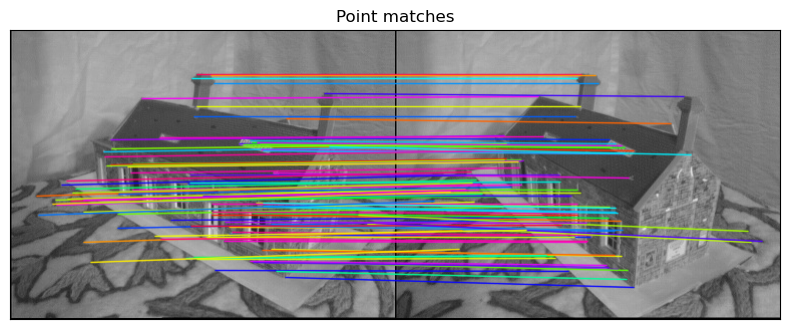

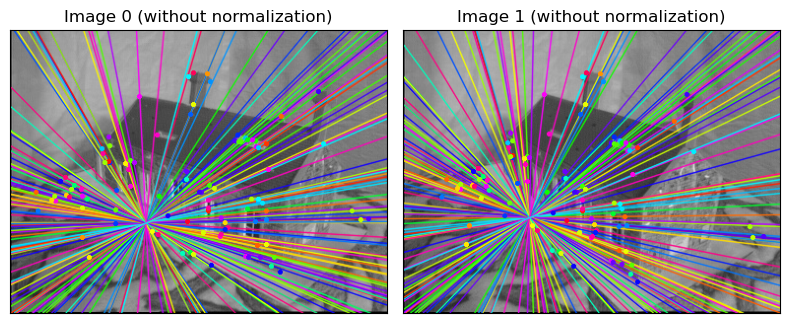

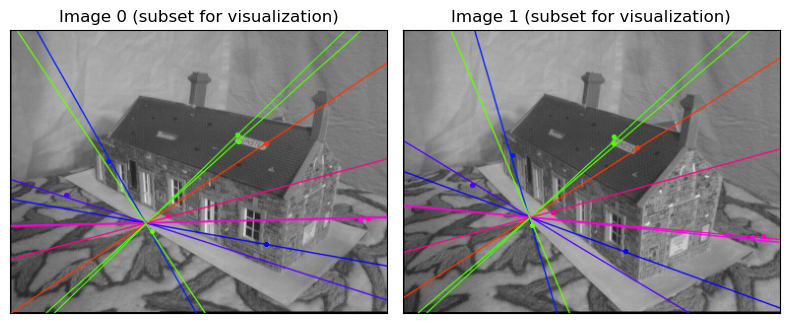

In [5]:
img0, img1, x0, x1, _, _ = load_data('house')
n_matches = 100
x0 = x0[:,:n_matches]
x1 = x1[:,:n_matches]    

F, e0, e1 = get_fundamental_matrix(x0, x1)
residual_error = get_residual_error(F, x0, x1)

print(f'The estimated fundamental matrix F is \n{F}')

plot_multiple([draw_point_matches(img0, img1, x0, x1)], 
              ['Point matches'], imwidth=8)
img0_result = draw_points_and_epipolar_lines(img0, x0, F @ x1)
img1_result = draw_points_and_epipolar_lines(img1, x1, F.T @ x0)
plot_multiple([img0_result, img1_result], 
              ['Image 0 (without normalization)', 'Image 1 (without normalization)'])

img0_result_sampled = draw_points_and_epipolar_lines(img0, x0[:, ::10], F @ x1[:, ::10])
img1_result_sampled = draw_points_and_epipolar_lines(img1, x1[:, ::10], F.T @ x0[:, ::10])
plot_multiple([img0_result_sampled, img1_result_sampled], 
              ['Image 0 (subset for visualization)', 'Image 1 (subset for visualization)'])

print(f'Epipole 0: {e0}, epipole 1: {e1}')
print(f'Fitting error: {residual_error:.1f} px')

How do you interpret the visualization? Is the estimated matrix good? Why or why not?

*POINTS: 0*

YOUR ANSWER HERE

## Normalization
As explained in the lecture, we need to take care of normalizing the points in order to make sure the estimation problem is well conditioned. Write a function `normalize_points` that normalizes the given list of 2D points (in homogenuous coordinates) `x` by first shifting their origin to the centroid and then scaling them such that their mean distance from the origin is $\sqrt{2}$. Since the input points are homogeneous, pay attention to divide them by their last component before processing them. The function should return both the transformed points and the $3 × 3$ transformation matrix $\mathrm{T}$.

In [6]:
# POINTS: 4

def normalize_points(x):
    """
    Args:
        x: 3xN arrays of N homogenous points in 2D
        
    Return:
        x_trans: 3xN matrix of transformed points
        T: the 3x3 transformation matrix, points_trans = T * points
    """
    # YOUR CODE HERE
    # raise NotImplementedError()
    x = x / x[2]
    center = np.mean(x, axis=1)
    T_center = np.array([[1, 0, -center[0]],
                         [0, 1, -center[1]],
                         [0, 0, 1]])
    x_trans = T_center @ x

    scale = np.sqrt(2) / np.mean(np.linalg.norm(x_trans[:2], axis=0))
    T_scale = np.array([[scale, 0, 0],
                        [0, scale, 0],
                        [0, 0, 1]])
    T = T_scale @ T_center
    x_trans = T @ x
    
    return x_trans, T

Now write an adapted function `get_fundamental_matrix_with_normalization` that first normalizes the input points, computes the fundamental matrix based on the normalized points, and then undoes the transformation by applying $\mathrm{F = T_0^⊤FT_1}$ before computing the epipoles.

In [7]:
# POINTS: 3

def get_fundamental_matrix_with_normalization(x0, x1):
    """
    Args:
        x0, x1: 3xN arrays of N homogenous points in 2D
        
    Returns:
        F: The 3x3 fundamental martix such that x0'*F*x1 = 0
        e0: The epipole in image 0 such that F'*e0 = 0
        e1: The epipole in image 1 such that F*e1 = 0 
    """
    # YOUR CODE HERE
    # raise NotImplementedError()
    x0 = x0 / x0[2]
    x1 = x1 / x1[2]
    
    x0_norm, T0 = normalize_points(x0)
    x1_norm, T1 = normalize_points(x1)
    F_norm, _, _ = get_fundamental_matrix(x0_norm, x1_norm)
    F = T0.T @ F_norm @ T1

    U, _, Vt = np.linalg.svd(F)
    e0 = U[:, -1] / U[-1, -1]
    e1 = Vt[-1, :] / Vt[-1, -1]
    
    return F, e0, e1

C:\Users\Haoling Yang\AppData\Local\Temp\ipykernel_23160\740770910.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img0 = imageio.imread(f'{d_name}1.jpg')
C:\Users\Haoling Yang\AppData\Local\Temp\ipykernel_23160\740770910.py:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(f'{d_name}2.jpg')


The estimated fundamental matrix F is 
[[ 5.51753355e-09  4.96874507e-06 -7.28741175e-06]
 [ 1.53686603e-06 -2.53781411e-07  1.22196065e-02]
 [-1.70946239e-05 -1.34047209e-02  2.09706039e-03]]
Epipole 0: [2.69788155e+03 1.43732234e+00 1.00000000e+00], epipole 1: [-7.94929021e+03  1.02939246e+01  1.00000000e+00]
Fitting error: 0.2 px


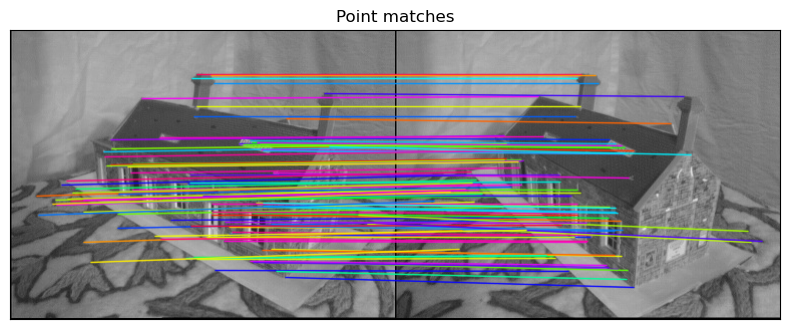

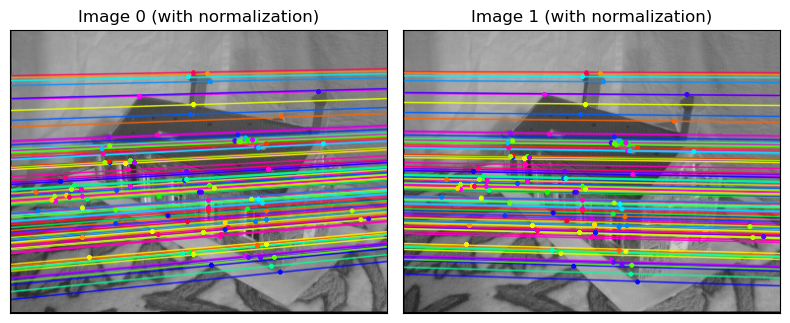

In [8]:
img0, img1, x0, x1, _, _ = load_data('house')

n_matches = 100
x0 = x0[:,:n_matches]
x1 = x1[:,:n_matches]

F, e0, e1 = get_fundamental_matrix_with_normalization(x0, x1)
residual_error = get_residual_error(F, x0, x1)
print(f'The estimated fundamental matrix F is \n{F}')

plot_multiple([draw_point_matches(img0, img1, x0, x1)], 
              ['Point matches'], imwidth=8)
img0_result = draw_points_and_epipolar_lines(img0, x0, F @ x1)
img1_result = draw_points_and_epipolar_lines(img1, x1, F.T @ x0)
plot_multiple([img0_result, img1_result], 
              ['Image 0 (with normalization)', 'Image 1 (with normalization)'])

print(f'Epipole 0: {e0}, epipole 1: {e1}')
print(f'Fitting error: {residual_error:.1f} px')

How can you visually verify the results? That is, what exactly do you need to look at in the result images to decide whether the algorithm worked well? Did the normalization help?

*POINTS: 0*

YOUR ANSWER HERE

## RANSAC
In practice, the correspondence set will always contain noise and outliers. We therefore apply RANSAC in order to get a robust estimate. It proceeds along the following steps:

1. Randomly select a (minimal) seed group of point correspondences on which to base the estimate.
2. Compute the fundamental matrix from this seed group.
3. Find inliers to this transformation.
4. If the number of inliers is sufficiently large $(≥ m)$, recompute the least-squares estimate of the fundamental matrix on all inliers.
5. Else, repeat for a maximum of k iterations.

The parameter $k$ can be chosen automatically. Suppose $w$ is the fraction of inlier correspondences and $n = 8$ correspondences are needed to define a hypothesis. Then the probability that a single sample of $n$ correspondences is correct is $w^n$, and the probability that all samples fail is $(1 − w^n)^k$. The standard strategy is thus, given an estimate for $w$, to choose $k$ high enough that this value is kept below our desired failure rate.

In the following, we will implement the different steps of the RANSAC procedure and apply it for robust estimation of the fundamental matrix.

First write a function which takes as input an estimated fundamental matrix and the full set of correspondence candidates and which returns the indices of the inliers. A point pair $x, x'$ is defined to be an inlier if the distance of $x$ to the epipolar line $l = \mathrm{F}^⊤x'$, as well as the opposite distance, are both less than some threshold $ε$.

In [9]:
# POINTS: 1

def get_inliers(F, x0, x1, eps):
    # YOUR CODE HERE
    # aise NotImplementedError()
    d0, d1 = get_residual_distance(F, x0, x1)
    indices = np.argwhere(
            np.logical_and(d0 < eps, d1 < eps))[...,0]
    return indices

Now write a function which implements the RANSAC procedure to estimate a fundamental matrix using the normalized eight-point algorithm. For randomly sampling matches, you can use `np.random.choice`. Here, we want to use a simple version of the algorithm that just runs for a fixed number of `n_iter` iterations and returns the solution with the largest inlier set.

In [10]:
# POINTS: 7

def get_fundamental_matrix_with_ransac(x0, x1, eps=10, n_iter=1000):
    """
    Args:
        x0, x1: 3xN arrays of N homogenoous points in 2D
        eps: Inlier threshold
        n_iter: Number of iterations
    
    Return:
        F: The 3x3 fundamental martix such taht x2'*F*x1 = 0
        e0: The epipole in image 1 such that F'*e0 = 0
        e1: The epipole in image 2 such that F*e1 = 0 
        inlier_ratio: Ratio of inlier
        inlier_indices: Indices of inlier
    """
    # YOUR CODE HERE
    # raise NotImplementedError()
    n_pts = x1.shape[1]
    n_sample = 8
    
    indices = np.arange(n_pts)
    best_inlier_indices = []

    for i in range(n_iter):
        sample_indices = np.random.choice(indices, size=n_sample, replace=True)
        x0_sample = x0[:, sample_indices]
        x1_sample = x1[:, sample_indices]
        F, e0, e1 = get_fundamental_matrix_with_normalization(x0_sample, x1_sample)

        inlier_indices = get_inliers(F, x0, x1, eps)        
        if len(inlier_indices) > len(best_inlier_indices):
            best_inlier_indices = inlier_indices
            
    if len(best_inlier_indices) < 8:
        raise RuntimeError('Too few inliers found.')
            
    F, e0, e1 = get_fundamental_matrix_with_normalization(
            x0[:, best_inlier_indices], x1[:, best_inlier_indices])
    
    return F, e0, e1, best_inlier_indices

Since we are working with precomputed ground-truth point correspondences loaded from file, we will artificially create outlier pairs using the following function. This is to simulate the effect of noisy point correspondence estimation.

In [11]:
def inject_outliers(img, x0, x1, outlier_ratio):
    """Artifically create outliers.
    
    Args:
        img: Image, used only for size
        x0, x1: Input 3xN points 
        outlier_ratio: Probability (ratio) of outlier
        
    Returns:
        x0_noisy, x1_noisy: Output points (with outlier)
        inlier_mask: 1D binary array
    """
    n_pts = x0.shape[1]
    h, w = img.shape[:2]
    
    outlier_mask = np.random.uniform(size=n_pts) < outlier_ratio
    n_outliers = sum(outlier_mask)
    outlier_x01 = np.random.randint(low=0, high=w, size=(2, n_outliers))
    outlier_y01 = np.random.randint(low=0, high=h, size=(2, n_outliers))
    
    x0_noisy, x1_noisy = x0.copy(), x1.copy()
    x0_noisy[0, outlier_mask] = np.random.randint(low=0, high=w, size=n_outliers)
    x0_noisy[1, outlier_mask] = np.random.randint(low=0, high=h, size=n_outliers)
    x1_noisy[0, outlier_mask] = np.random.randint(low=0, high=w, size=n_outliers)
    x1_noisy[1, outlier_mask] = np.random.randint(low=0, high=h, size=n_outliers)

    return x0_noisy, x1_noisy, np.invert(outlier_mask)

C:\Users\Haoling Yang\AppData\Local\Temp\ipykernel_23160\740770910.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img0 = imageio.imread(f'{d_name}1.jpg')
C:\Users\Haoling Yang\AppData\Local\Temp\ipykernel_23160\740770910.py:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(f'{d_name}2.jpg')


-------- Without RANSAC --------
The estimated fundamental matrix F is 
[[-4.43322104e-06 -2.10440856e-05  2.68487400e-03]
 [ 2.82266557e-05  6.78955954e-06  4.89331690e-03]
 [-3.85885474e-03 -7.67306953e-03  4.96974620e-01]]
Epipole 0: [-337.61949756   83.68376696    1.        ], epipole 1: [-214.93795968  172.86289137    1.        ]
Fitting error: 14.2 px
-------- With RANSAC --------
The estimated fundamental matrix F is 
[[ 1.39883947e-06 -7.71813621e-06  2.09294056e-03]
 [ 1.74614881e-05  2.20301414e-06  9.58159499e-03]
 [-3.20450582e-03 -1.19746264e-02  1.84042942e-01]]
Epipole 0: [-1.46559723e+03  3.00927448e+02  1.00000000e+00], epipole 1: [-569.90789319  167.88132075    1.        ]
Fitting error: 0.2 px
Inlier ratio: 72% (groundtruth: 75%)


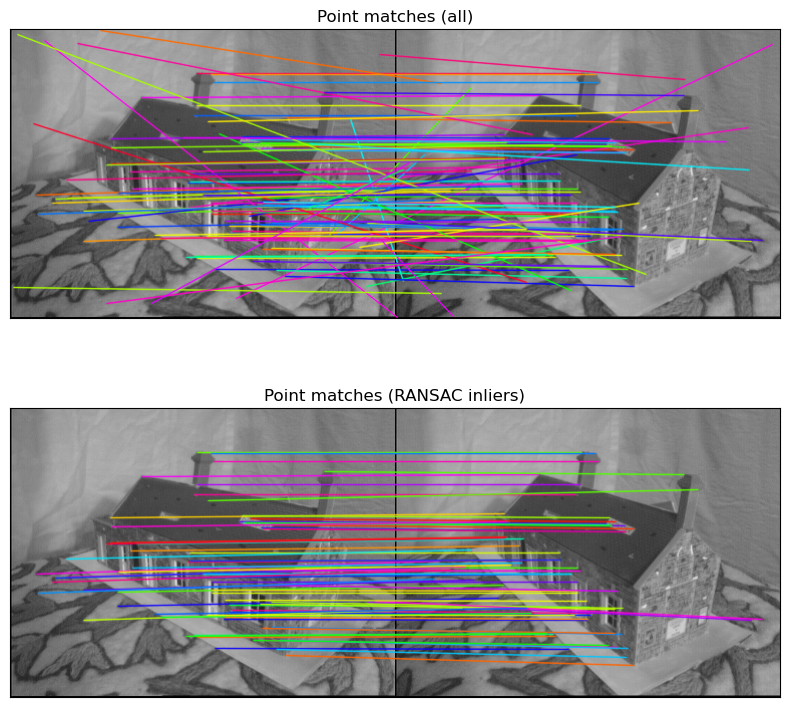

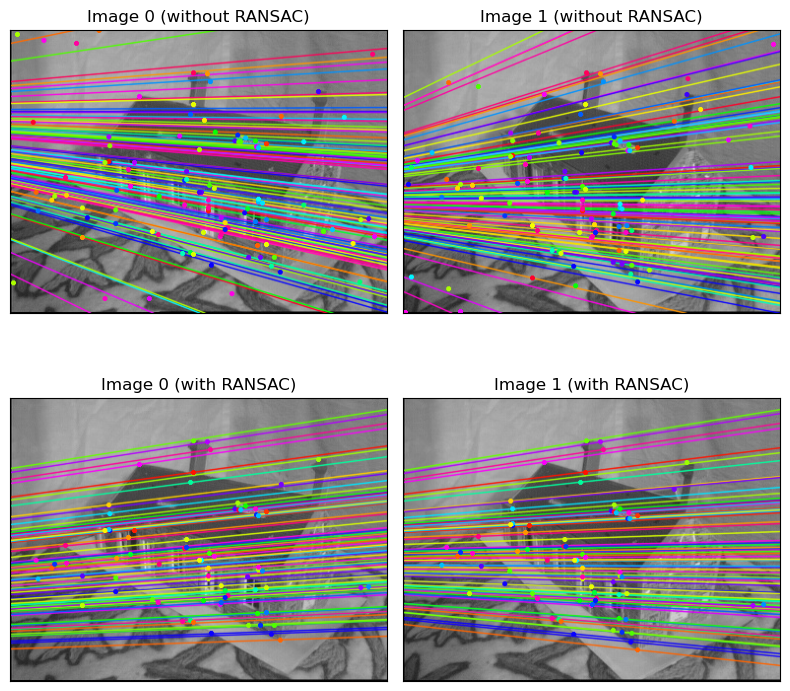

In [12]:
img0, img1, x0, x1, _, _ = load_data('house')
n_matches = 100
x0 = x0[:, :n_matches]
x1 = x1[:, :n_matches]
x0, x1, inlier_mask = inject_outliers(img0, x0, x1, outlier_ratio=0.3)
x0_inlier, x1_inlier = x0[:, inlier_mask], x1[:, inlier_mask]
inlier_ratio = sum(inlier_mask) / x0.shape[1]

# Without RANSAC
F_vanilla, e0_vanilla, e1_vanilla = get_fundamental_matrix_with_normalization(x0, x1)
residual_error_vanilla = get_residual_error(F_vanilla, x0_inlier, x1_inlier)
print('-------- Without RANSAC --------')
print(f'The estimated fundamental matrix F is \n{F_vanilla}')
print(f'Epipole 0: {e0_vanilla}, epipole 1: {e1_vanilla}')
print(f'Fitting error: {residual_error_vanilla:.1f} px')

# With RANSAC
eps = 1
n_iter = 1000
F_ransac, e0_ransac, e1_ransac, inlier_indices = get_fundamental_matrix_with_ransac(
    x0, x1, eps, n_iter)
residual_error_ransac = get_residual_error(F_ransac, x0_inlier, x1_inlier)
inlier_ratio_ransac = len(inlier_indices) / x0.shape[1]
inlier_mask_ransac = np.zeros(x0.shape[1], dtype=bool)
inlier_mask_ransac[inlier_indices] = True
print('-------- With RANSAC --------')
print(f'The estimated fundamental matrix F is \n{F_ransac}')
print(f'Epipole 0: {e0_ransac}, epipole 1: {e1_ransac}')
print(f'Fitting error: {residual_error_ransac:.1f} px')
print(f'Inlier ratio: {inlier_ratio_ransac:.0%} (groundtruth: {inlier_ratio:.0%})')

# Plotting
plot_multiple([draw_point_matches(img0, img1, x0, x1),
              draw_point_matches(img0, img1, x0[:, inlier_mask_ransac], x1[:, inlier_mask_ransac])], 
              ['Point matches (all)',
              'Point matches (RANSAC inliers)'], imwidth=8, max_columns=1)

img0_vanilla = draw_points_and_epipolar_lines(img0, x0, F_vanilla @ x1)
img1_vanilla = draw_points_and_epipolar_lines(img1, x1, F_vanilla.T @ x0)
img0_ransac = draw_points_and_epipolar_lines(img0, x0_inlier, F_ransac @ x1_inlier)
img1_ransac = draw_points_and_epipolar_lines(img1, x1_inlier, F_ransac.T @ x0_inlier)
plot_multiple([img0_vanilla, img1_vanilla, img0_ransac, img1_ransac], 
              ['Image 0 (without RANSAC)', 'Image 1 (without RANSAC)',
               'Image 0 (with RANSAC)', 'Image 1 (with RANSAC)'], max_columns=2)

## Triangulation
As a final step, we want to reconstruct the observed points in 3D by triangulation. Note that just using two images, this is not possible without a calibration. For this exercise, the calibration matrices are provided as a $3 × 4$ matrix.

For triangulation, we use the linear algebraic approach from the lecture. Given a 2D point correspondence $\mathrm{x_1, x_2}$ in homogeneous coordinates, the 3D point location $\mathrm{X}$ is given as follows:

$$
\lambda_1x_1 = \mathrm{P}_1X
$$

$$
\lambda_2x_2 = \mathrm{P}_2X
$$

We can now build the cross-product of each point with both sides of the equation and obtain

$$
x_1 \times \mathrm{P}_1X = [\mathrm{x_1}_\times]\mathrm{P}_1X = 0
$$

$$
x_2 \times \mathrm{P_2}X = [\mathrm{x_2}_\times]\mathrm{P}_2X = 0
$$

where we used the skew-symmetrix matrices $[\mathrm{x_i}_\times]$ to replace the cross products

$$
a \times b = [\mathrm{a}_\times]b = \left[\begin{matrix}0&-a_z&a_y \cr a_z&0&-a_x \cr -a_y&a_x&0\end{matrix}\right]b.
$$

Each 2D point provides 2 independent equations for a total of 3 unknowns. We can therefore solve the overconstrained system by stacking the first two equations for each point in a matrix $\mathrm{A}$ and computing the least-squares solution for $\mathrm{A}X = 0$.

First write a function to find the centers of both cameras. Recall from the lecture that the camera centers are given by the null space of the camera matrices. They can thus be found by taking the SVD of the camera matrix and taking the last column of $\mathrm{V}$ normalized by the 4th entry.

In [13]:
# POINTS: 2

def camera_center_from_projection_matrix(P):
    # YOUR CODE HERE
    # raise NotImplementedError()
    _, _, Vt = np.linalg.svd(P)
    center = Vt[-1, :-1] / Vt[-1,-1]
    return center

In [14]:
img0, img1, x0, x1, P0, P1 = load_data('house')
C0 = camera_center_from_projection_matrix(P0)
C1 = camera_center_from_projection_matrix(P1)

print(f'P0: {P0}')
print(f'P1: {P1}')
print(f'C0: {C0}')
print(f'C1: {C1}')

P0: [[ 1.6108033e+01  1.3704159e+01 -6.7351564e+01 -1.8838024e+02]
 [ 8.2886212e-01 -6.1257005e+01 -2.7985739e+01 -7.4190016e+00]
 [ 1.6739784e-01 -4.5720139e-02 -8.4811075e-02  5.6548906e-01]]
P1: [[ 1.0571624e+01  4.0812730e+00 -2.2538413e+01 -5.9593366e+01]
 [ 3.1827253e-01 -2.1616617e+01 -9.8820962e+00 -2.7146868e+00]
 [ 6.1142503e-02 -2.0656640e-02 -2.0701037e-02  2.5211789e-01]]
C0: [-4.82245697  1.48072657 -3.64903811]
C1: [-5.04951907  1.93166599 -4.66276516]


C:\Users\Haoling Yang\AppData\Local\Temp\ipykernel_23160\740770910.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img0 = imageio.imread(f'{d_name}1.jpg')
C:\Users\Haoling Yang\AppData\Local\Temp\ipykernel_23160\740770910.py:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(f'{d_name}2.jpg')


Now write a function `triangulate` that uses linear least-square method to triangulate the position of a matching point pair in 3D, as described above. A well suited helper function is `vector_to_skew` which returns a skew symmetric matrix from the vector v with 3 elements.

In [15]:
def vector_to_skew(vec):
    return np.array([
        [      0, -vec[2], vec[1]],
        [ vec[2],       0,-vec[0]],
        [-vec[1], vec[0],       0]
    ])

In [16]:
# POINTS: 5

def triangulate(x0, x1, P0, P1):
    """ Triangulate matching points.
    Args:
        x0, x1: 3xN matrices of matching points (homogeneous)
        P0, P1: 3X4 camera matrices

    Returns:
        X: 3xN matrix of points in world space
    """
    # YOUR CODE HERE
    # raise NotImplementedError()
    X = np.empty((4, x0.shape[1]), dtype=np.float64)
    for i in range(x0.shape[1]):
        A = np.concatenate([
            vector_to_skew(x0[:, i])[:2] @ P0,
            vector_to_skew(x1[:, i])[:2] @ P1], axis=0)
        _, _, Vt = np.linalg.svd(A, full_matrices=False)
        X[:, i] = Vt[-1, :] / Vt[-1, -1]
    return X

Write a function to compute the reprojection errors (average distance) between the observed 2D points and the projected 3D points in the two images. 

In [17]:
# POINTS: 2

def get_reprojection_error(X, x, P):
    # YOUR CODE HERE
    # raise NotImplementedError()
    x_p = P @ X
    res = x - x_p / x_p[2, :]
    distance = np.hypot(res[0, :], res[1, :])
    return np.mean(distance)

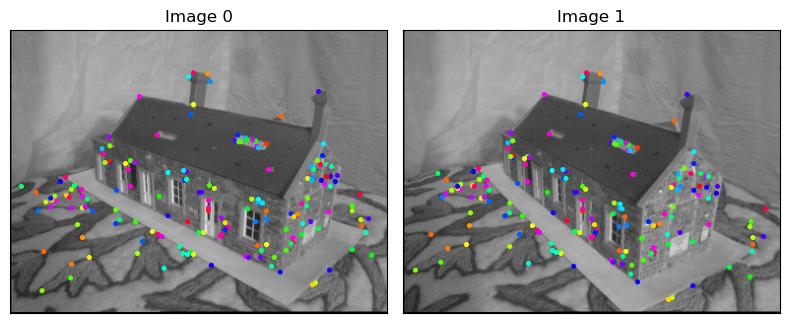

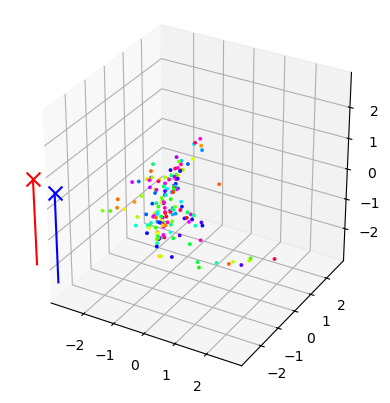

Reprojection error: 0.10 px


In [18]:
def plot_3d_reconstruction(X, C0, C1, centered=False, lim=None):
    if not centered:
        center = X.max(1) / 2 + X.min(1) / 2
        X = X - center[:, None]
        C0 = C0 - center
        C1 = C1 - center
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    c = colors[:X.shape[1]]/255
    ax.scatter(X[0], X[1], X[2], c=c, alpha=1, s=3)
    ax.scatter(C0[0], C0[1], C0[2], color='red', s=100, marker='x')
    ax.scatter(C1[0], C1[1], C1[2], color='blue', s=100, marker='x')
    ax.plot([C0[0], C0[0]], [C0[1], C0[1]], [C0[2], min(X[2])], color='red')
    ax.plot([C1[0], C1[0]], [C1[1], C1[1]], [C1[2], min(X[2])], color='blue')
    ax.set_box_aspect([1,1,1])
    if lim is None:
        lim = np.max(np.abs(X))
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)
    plt.show()

X = triangulate(x0, x1, P0, P1)
error0 = get_reprojection_error(X, x0, P0)
error1 = get_reprojection_error(X, x1, P1)
error = 0.5 * (error0 + error1)

# Rotate the visualization to be more recognizable.
U,S,Vt = np.linalg.svd(P0[:3,:3], full_matrices=False)
rot = U @ Vt
rot = np.array([[1,0,0], [0,0,1], [0,-1,0]]) @ rot

plot_multiple([draw_keypoints(img0, x0), draw_keypoints(img1, x1)], 
              ['Image 0', 'Image 1'])
plot_3d_reconstruction(rot @ X[:3]/X[3], rot @ C0, rot @ C1)
print(f'Reprojection error: {error:.2f} px')

The following cell rotates the point in 3D space for better visualization. Does the result look correct?

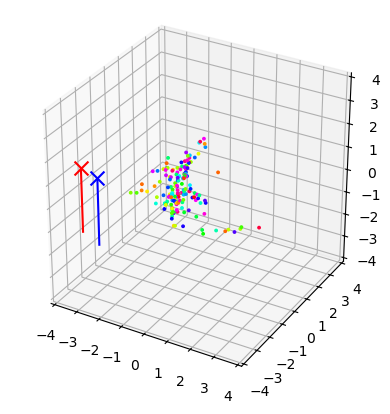

In [19]:
from IPython.display import clear_output
from time import sleep
alphs = 1-np.cos(np.linspace(0, 2*np.pi, 50))
center = X.max(1) / 2 + X.min(1) / 2
X_c = X[:3] - center[:3, None]
C0_c = C0 - center[:3]
C1_c = C1 - center[:3]
for _ in range(5):
    for alph in alphs:
        sleep(1/30)
        rotrot = np.array([[np.cos(alph), -np.sin(alph), 0], [np.sin(alph), np.cos(alph), 0], [0, 0, 1]]) @ rot
        clear_output(wait=True)
        plot_3d_reconstruction(rotrot @ X_c, rotrot @ C0_c, rotrot @ C1_c, centered=True, lim=4)